# Project 2
Group member:

Xiang Xinye,
Siew Julian,
Lee Wesker,
Khoi Pham,
Tan Jie Heng Alfred,
Shahrul Al-Nizam Ling

## Import

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates

%matplotlib inline

## Plot helper method

In [28]:
def plot(y, title=r'title', x_label=r'xlabel', y_label=r'ylabel'):
    
    fig, ax = plt.subplots(1, 1)
    
    ax.set_facecolor('.85')
    ax.plot(y, linewidth=0.5, color='blue')
    
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
    # set formatter
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # set font and rotation for date tick labels
    plt.gcf().autofmt_xdate()
    
    ax.grid(color='white', linewidth=0.5)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()

def plot_decompose(decom_result):
    fig, axes = plt.subplots(4, 1, sharex=True)
    
    decom_result.observed.plot(ax=axes[0], legend=False, color='k')
    axes[0].set_ylabel('Observed')
    decom_result.trend.plot(ax=axes[1], legend=False, color='r')
    axes[1].set_ylabel('Trend')
    decom_result.seasonal.plot(ax=axes[2], legend=False, color='g')
    axes[2].set_ylabel('Seasonal')
    decom_result.resid.plot(ax=axes[3])
    axes[3].set_ylabel('Residual')
    
    for ax in axes:
        ax.grid(color='white', linewidth=0.5)
    
    plt.show()

## Data Analysis

### Dataset Overview

In [29]:
# read data and format
df = pd.read_csv('drug.txt')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index(df['date'])
df = df.drop(columns=['date'])
print(df.head())        # visualize first 5 rows
print(df.tail())        # visualize last 5 rows
print(len(df.index))    # Get number of entries
print(df.dtypes)        # See datatype of entries
print(df[df.isnull().any(axis=1)])


               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869
                value
date                 
2008-02-01  21.654285
2008-03-01  18.264945
2008-04-01  23.107677
2008-05-01  22.912510
2008-06-01  19.431740
204
value    float64
dtype: object
Empty DataFrame
Columns: [value]
Index: []


###  Time Plot

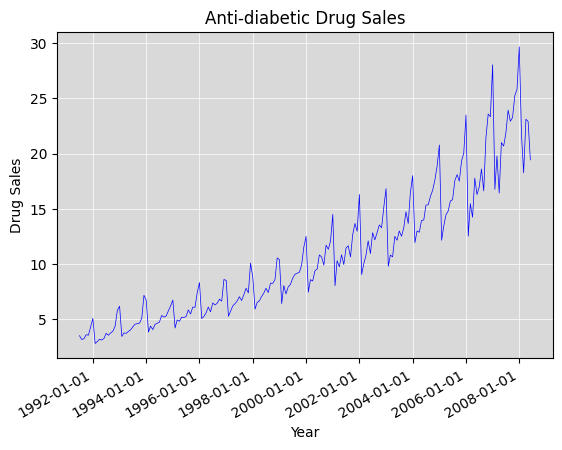

In [30]:
# original time series plot
plot(df["value"],
     title=r'Anti-diabetic Drug Sales',
     x_label=r'Year',
     y_label=r'Drug Sales')


### Seasonal Decomposition & ACF & PACF

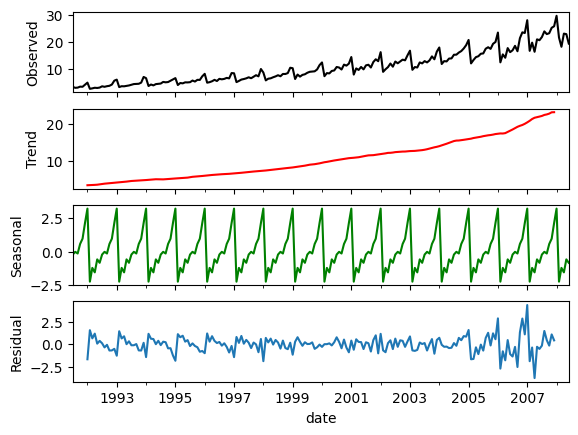

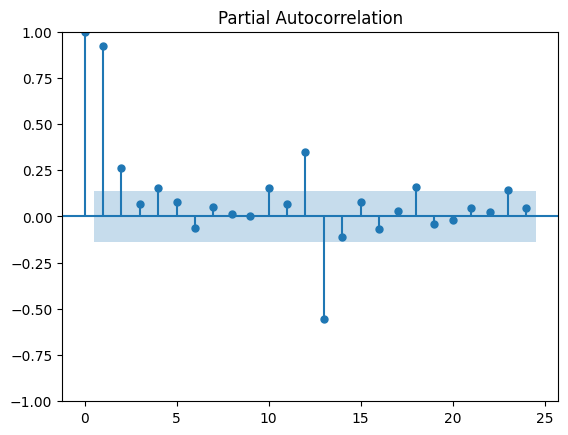

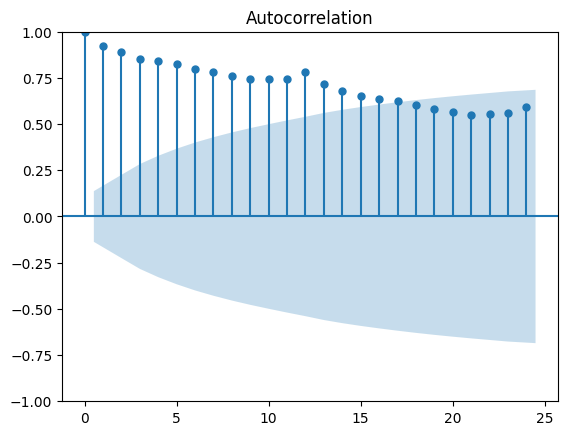

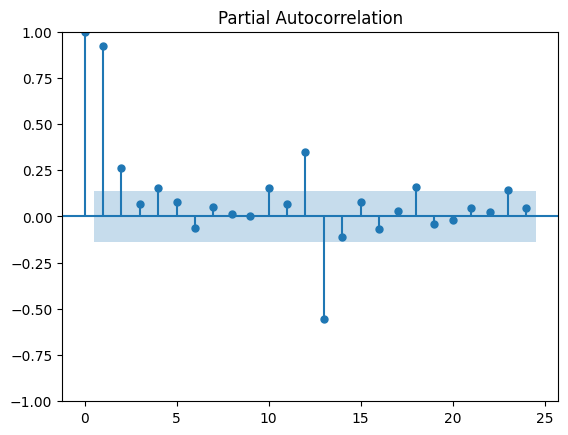

In [31]:
# seasonal decomposition
result = seasonal_decompose(df, model='additive')
plot_decompose(result)

# acf and pacf of original data
plot_acf(df)
plot_pacf(df)

## Data Transformation
### Box Cox Transformation

Lambda value: 0.061505584870954325


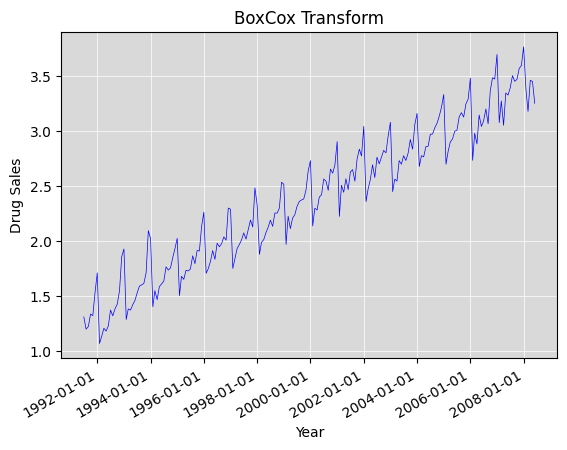

In [32]:
# boxcox transform
df['value_box_cox'], lambda_val = boxcox(df['value'])
print("Lambda value:", lambda_val)
# plot after boxcox transform
plot(df["value_box_cox"],
     title=r'BoxCox Transform',
     x_label=r'Year',
     y_label=r'Drug Sales')

### One Time Difference

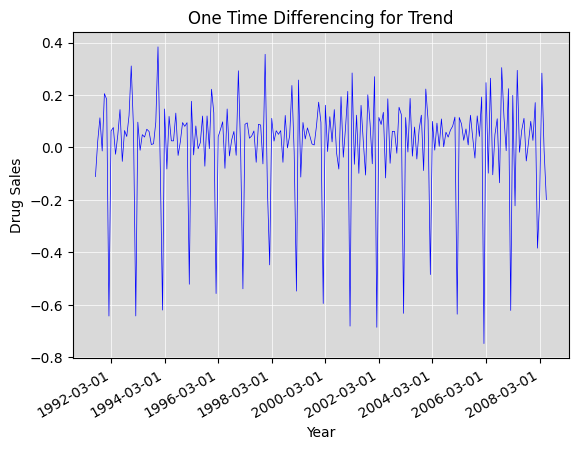

In [33]:
# one time differencing of data (trend)
df_one_diff = df.diff()
# plot one time differenced data
plot(df_one_diff["value_box_cox"],
     title=r'One Time Differencing for Trend',
     x_label=r'Year',
     y_label=r'Drug Sales')

### Seasonal Difference

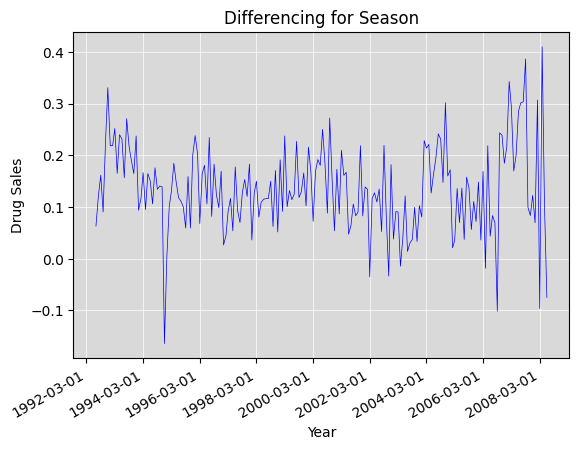

In [34]:
# one time differencing of data (seasonal)
df_one_diff = df.diff(periods=12)
# plot one time differenced data
plot(df_one_diff["value_box_cox"],
     title=r'Differencing for Season',
     x_label=r'Year',
     y_label=r'Drug Sales')

## SARIMA Modeling

### Automaticalling find the best SARIMA model parameters

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-456.800, Time=1.32 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-397.482, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-409.056, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-437.215, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-156.435, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-412.587, Time=0.21 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-424.113, Time=0.66 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-438.637, Time=0.58 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-463.396, Time=1.36 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=-415.690, Time=0.23 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : 

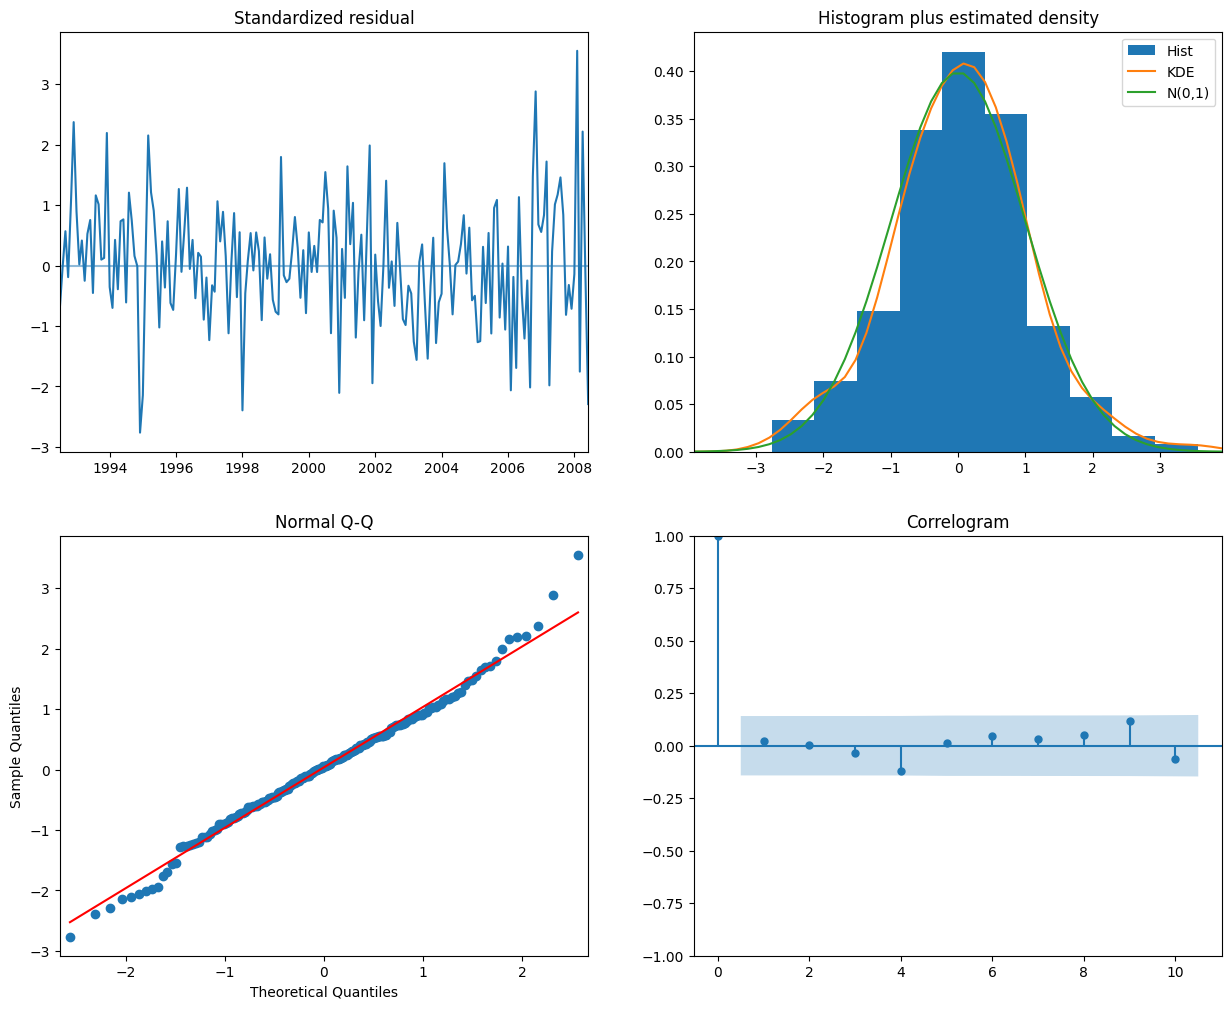

In [35]:
model = pm.auto_arima(df['value_box_cox'], start_p=1, start_q=1,
                       test='adf',  
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

print(model.summary())
model.plot_diagnostics(figsize=(15, 12))
plt.show()

### Train the model

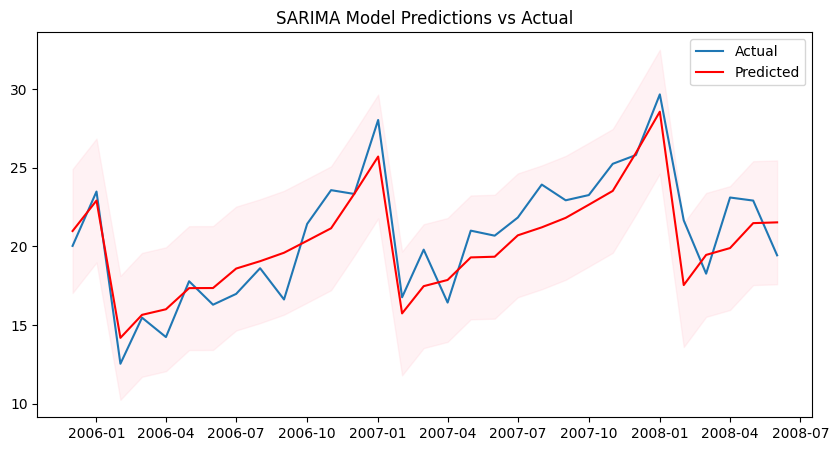

Test RMSE: 1.753


In [36]:
# Time series split into training and test sets
train_size = int(len(df) * 0.85)
train, test = df['value_box_cox'][:train_size], df['value_box_cox'][train_size:]

# Training model
model.fit(train)

# Forecasting test set
predictions = model.predict(n_periods=len(test))
predictions = inv_boxcox(predictions, lambda_val)

# Actual values and predicted values
test_actual = inv_boxcox(test, lambda_val)
plt.figure(figsize=(10,5))
plt.plot(test_actual.index, test_actual, label='Actual')
plt.plot(test_actual.index, predictions, color='red', label='Predicted')
plt.fill_between(test_actual.index, predictions - np.std(test_actual), predictions + np.std(test_actual), color='pink', alpha=0.2)
plt.title('SARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate the RMSE of test set
rmse = np.sqrt(mean_squared_error(test_actual, predictions))
print(f'Test RMSE: {rmse:.3f}')

### Forecast

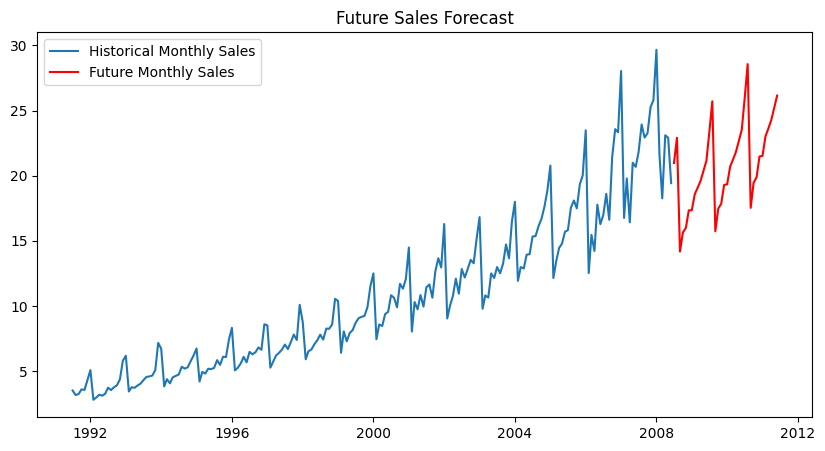

In [37]:
future_forecast = model.predict(n_periods=36)
future_forecast = inv_boxcox(future_forecast, lambda_val)

#Calculate the date
start_date = pd.to_datetime(df.index[-1]) + pd.offsets.MonthEnd(1)

future_dates = pd.date_range(start=start_date, periods=36, freq='M')

# Plot
plt.figure(figsize=(10,5))
plt.plot(df.index, inv_boxcox(df['value_box_cox'], lambda_val), label='Historical Monthly Sales')
plt.plot(future_dates, future_forecast, color='red', label='Future Monthly Sales')
plt.title('Future Sales Forecast')
plt.legend()
plt.show()

### Plot prediction with confidence zone

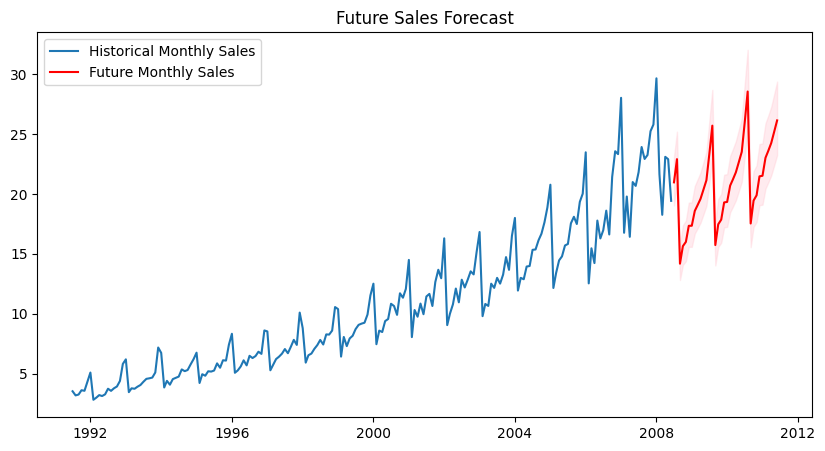

In [38]:
# Predictiond
future_forecast, conf_int = model.predict(n_periods=36, return_conf_int=True)
future_forecast = inv_boxcox(future_forecast, lambda_val)
conf_int = inv_boxcox(conf_int, lambda_val)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df.index, inv_boxcox(df['value_box_cox'], lambda_val), label='Historical Monthly Sales')
plt.plot(future_dates, future_forecast, color='red', label='Future Monthly Sales')

plt.fill_between(future_dates, 
                 conf_int[:, 0], conf_int[:, 1], 
                 color='pink', alpha=0.3)

plt.title('Future Sales Forecast')
plt.legend()
plt.show()

## Holt-Winter's Model

### Utils

In [39]:
def split_data(data, p = 0.8):
  idx = int(len(data) * p)
  X = data.iloc[:idx, :]
  y = data.iloc[idx:, :]
  return X, y

def plot_model(train, test, trend):
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.set_title('Holt Winters Model for predicting Drug Sales')
  ax.set_xlabel('Date')
  ax.set_ylabel('Sales')
  train['value'].plot(ax=ax, label='Train', legend=True)
  train['HW'].plot(ax=ax, label=f'Holt Winters fitting (type: {trend})', legend=True)
  test['value'].plot(ax=ax, label='Test', legend=True)
  test['HW'].plot(ax=ax, label='Holt Winters forecast', legend=True)
  ax.legend()
  plt.show()

def boxcox_transform(data, lmbda=None):
  transformed_data = boxcox(data, lmbda = lmbda)
  return (transformed_data[0], transformed_data[1])

def HW_exponential_smoothing(data, alpha, beta, trend="add", seasonal="add", seasonal_periods = 12, damped_trend=False):
  return ExponentialSmoothing(data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, use_boxcox=False, damped_trend=damped_trend).fit(smoothing_level=alpha, smoothing_slope=beta)

def inv_boxcox(data, lmbda):
  return (data * lmbda + 1) ** (1/lmbda)

def residual(data, pred):
  return data - pred

def diagnostic_checking(residuals):
  norm_resid = (residuals - np.mean(residuals)) / np.std(residuals)
  y = np.max(np.abs(norm_resid))

  fig, ax = plt.subplots(2, 1, figsize=(10, 5))

  for i in range(len(residuals)):
    ax[0].plot(len(norm_resid) * [0], color='w')
    ax[0].axvline(x=i, ymin=0.5, ymax=0.5+norm_resid[i]/y, color='r')
  ax[0].set_title('Standardized Residuals')
  ax[0].set_xlabel("Time")

  ax[1].plot(acorr_ljungbox(residuals, lags=5, return_df=True)['lb_pvalue'], \
             'bx')
  ax[1].plot(np.arange(1, 6), [0.05] * 5, 'r--')
  ax[1].set_title('p value for Ljung-Box statistic')
  ax[1].set_ylabel('p value')
  ax[1].set_xlabel('lag')
  fig.tight_layout()
  plt.show()

def rmse_prediction(HWmodel, test, lmbda):
    rmse_test_prediction = inv_boxcox(HWmodel.forecast(len(test)), lmbda)
    print("Forecast (test) RMSE: %.3f" %np.sqrt(mean_squared_error(test['value'], rmse_test_prediction)))

def forecast(data, HWmodel, n, lmbda):
  today = data.index[-1]
  target = today + pd.DateOffset(years=n)
  datalist = pd.date_range(today, target, freq='M')
  forecast_data = pd.DataFrame({'date': datalist, 'value': np.nan})
  forecast_data = forecast_data.set_index('date')


  forecast_data['value'] = HWmodel.forecast(len(forecast_data))
  forecast_data['value'] = inv_boxcox(forecast_data['value'], lmbda)
  data['HW'] = HWmodel.fittedvalues
  data['HW'] = inv_boxcox(data['HW'], lmbda)


  fig, ax = plt.subplots(figsize=(10, 6))
  ax.set_title(f'Holt Winters Model for predicting Drug Sales in the next {int(n)} years')
  ax.set_xlabel('Date')
  ax.set_ylabel('Sales')
  data['value'].plot(ax=ax, label='Train', legend=True)
  data['HW'].plot(ax=ax, label='Holt Winters fitting', legend=True)
  forecast_data['value'].plot(ax=ax, label='Holt Winters forecast', legend=True)
  ax.legend()
  plt.show()

### Train and forecast

/var/folders/y5/wl27bdwj1nb6bmfrz51m08pr0000gn/T/ipykernel_37621/1814049924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['box cox'] = transformed_data
/Users/aenea/anaconda3/envs/cv_detect/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/y5/wl27bdwj1nb6bmfrz51m08pr0000gn/T/ipykernel_37621/986971010.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].axvline(x=i, ymin=0.5, ymax=0.5+norm_res

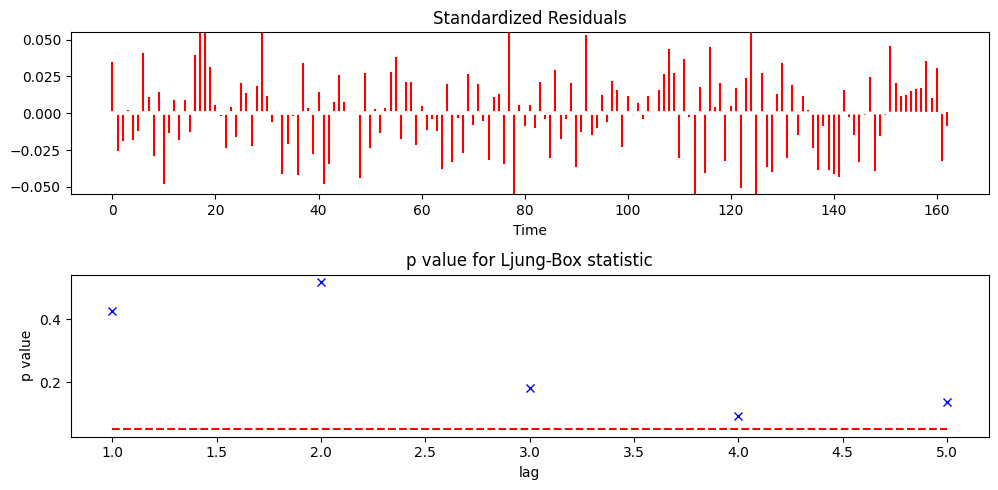

/var/folders/y5/wl27bdwj1nb6bmfrz51m08pr0000gn/T/ipykernel_37621/1814049924.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['HW'] = HWmodel.fittedvalues
/var/folders/y5/wl27bdwj1nb6bmfrz51m08pr0000gn/T/ipykernel_37621/1814049924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['HW'] = inv_boxcox(train['HW'], lmbda)
/var/folders/y5/wl27bdwj1nb6bmfrz51m08pr0000gn/T/ipykernel_37621/1814049924.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

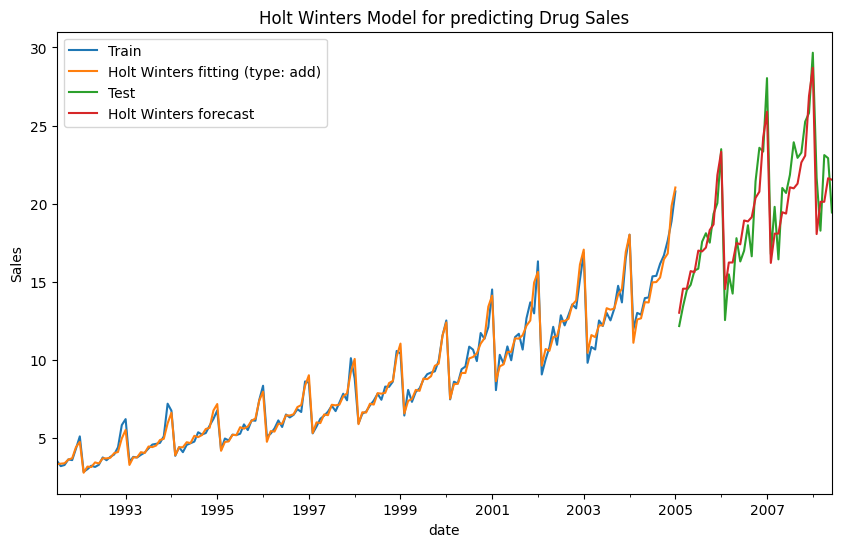

Forecast (test) RMSE: 1.601
                       ExponentialSmoothing Model Results                       
Dep. Variable:                  box cox   No. Observations:                  163
Model:             ExponentialSmoothing   SSE                              0.583
Optimized:                         True   AIC                           -886.185
Trend:                         Additive   BIC                           -836.685
Seasonal:                      Additive   AICC                          -881.435
Seasonal Periods:                    12   Date:                 Sat, 13 Apr 2024
Box-Cox:                          False   Time:                         16:46:14
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1734813                alpha                 Tr

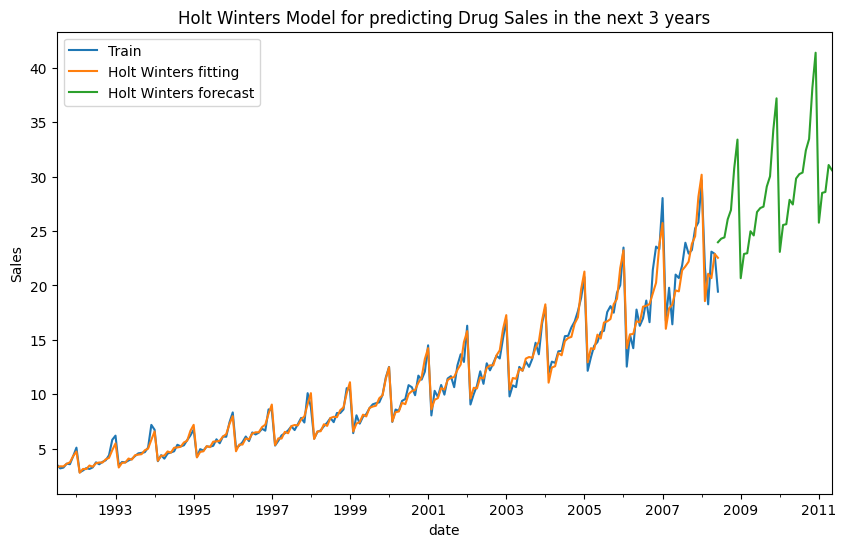

In [40]:
trend = 'add'
seasonal = 'add'

train, test = split_data(df)
(transformed_data, lmbda) = boxcox_transform(train['value'])
train['box cox'] = transformed_data
HWmodel = HW_exponential_smoothing(train['box cox'], alpha=None, beta=None, trend=trend, seasonal=seasonal, seasonal_periods=12)
residuals = residual(train['box cox'], HWmodel.fittedvalues)
diagnostic_checking(residuals)
train['HW'] = HWmodel.fittedvalues
train['HW'] = inv_boxcox(train['HW'], lmbda)
test['HW'] = HWmodel.forecast(len(test))
test['HW'] = inv_boxcox(test['HW'], lmbda)
plot_model(train, test, trend)
rmse_prediction(HWmodel, test, lmbda)
print(HWmodel.summary())

# forcast next 3 years
(transformed_data, lmbda) = boxcox_transform(df['value'])
HWmodel = HW_exponential_smoothing(transformed_data, alpha=None, beta=None, trend=trend, seasonal=seasonal, seasonal_periods=12)
forecast(df, HWmodel, 3, lmbda)

